## Ensemble

In [1]:
!nvidia-smi

Mon Mar 13 12:57:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   30C    P8     7W / 320W |      5MiB / 10018MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install segmentation_models_pytorch

In [3]:
!pip install timm

In [4]:
import timm
import random
import pandas as pd
import numpy as np
import os
import glob
import cv2
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings(action='ignore') 

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import albumentations as albu
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as transforms
import sklearn
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast 
import segmentation_models_pytorch as smp

In [5]:
print('numpy verison :', np.__version__)
print('pandas version :', pd.__version__)
print('opencv version :', cv2.__version__)
print('torch version :', torch.__version__)
print('sklearn verison :', sklearn.__version__)
print('albumentations version :', albu.__version__)

numpy verison : 1.19.5
pandas version : 1.1.5
opencv version : 4.5.2
torch version : 1.7.0
sklearn verison : 0.24.2
albumentations version : 1.0.0


In [6]:
CFG = {
    'WIDTH':48,
    'HEIGHT':72,
    'EPOCHS':10,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':128,
    'SEED':41
}

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [8]:
simulation_sem_paths = sorted(glob.glob('./data/simulation_data/SEM/*/*/*.png'))

simulation_depth_paths = sorted(glob.glob('./data/simulation_data/Depth/*/*/*.png')*4)

test_sem_path_list = sorted(glob.glob('./data/test/SEM/*.png'))

train_sem_path_list = sorted(glob.glob('./data/train/SEM/*/*/*.png'))

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
#     torch.backends.cudnn.enabled = False
seed_everything(CFG['SEED']) # Seed 고정

## Classification

In [10]:
class CustomDataset(Dataset):
    def __init__(self, sem_path_list):
        self.sem_path_list = sem_path_list


    def __getitem__(self, index):
#         transform = transforms.Pad((8,12,8,12))
        
        sem_path = self.sem_path_list[index]
        sem_img = cv2.imread(sem_path, cv2.IMREAD_GRAYSCALE)
        sem_img = np.expand_dims(sem_img, axis=-1).transpose(2,0,1)
        sem_img = sem_img / 255.
        sem_img = torch.Tensor(sem_img)
        return sem_img # B,C,H,W

        
    def __len__(self):
        return len(self.sem_path_list)

In [11]:
test_dataset = CustomDataset(test_sem_path_list)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)
model_names = ['resnet50', 'resnet34']

#efficientnet_b3

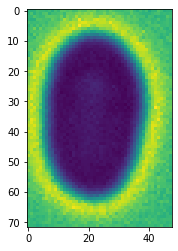

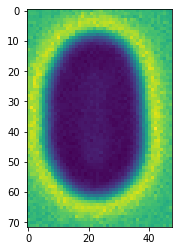

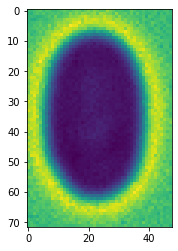

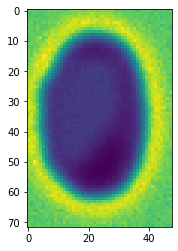

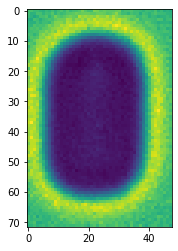

In [12]:
cnt = 0
for sem_img in test_loader:
    plt.imshow(sem_img[0][0])
    plt.show()
    cnt+= 1
    if cnt == 5:
        break

In [13]:
ensembles = []
for model_name in model_names:
    probs = []
    outer_model = timm.create_model(model_name, pretrained = False, in_chans=1, num_classes=4).to(device)
    outer_model.load_state_dict(torch.load("./weight/outer_model_"+model_name+".pt"))
    for i, sem_img in tqdm(enumerate(test_loader), total=len(test_loader)):
        outer_model.eval()
        with torch.no_grad():
            sem_img = sem_img.float().to(device)
            preds = F.softmax(outer_model(sem_img))
#             print(preds.shape)
            probs.append(preds.cpu().detach().numpy())
    pred_probs = np.concatenate(probs)
#     print(pred_probs.shape)
    ensembles.append(pred_probs)


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

In [14]:
ensemble_prob = np.mean(ensembles, axis=0)

In [15]:
ensemble_prob.shape

(25988, 4)

In [16]:
cls = np.argmax(ensemble_prob, axis=1)

In [17]:
for c in cls:
    print(c)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


## Depth map

In [18]:
class CustomDataset(Dataset):
    def __init__(self, sem_path_list):
        self.sem_path_list = sem_path_list

        self.transform = albu.Compose([
                    ToTensorV2(),
                ])


    def __getitem__(self, index):
        transform = transforms.Pad((8,12,8,12))
        
        sem_path = self.sem_path_list[index]
        sem_img = cv2.imread(sem_path, cv2.IMREAD_GRAYSCALE)
        sem_img = sem_img / 255.
        
        transformed = self.transform(image = sem_img)
        sem_img = transformed['image']
        return transform(sem_img)

        
    def __len__(self):
        return len(self.sem_path_list)

In [19]:
test_dataset = CustomDataset(test_sem_path_list)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)
model_names = ['Unet', 'Linknet']

torch.Size([128, 1, 96, 64])


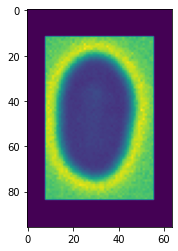

torch.Size([128, 1, 96, 64])


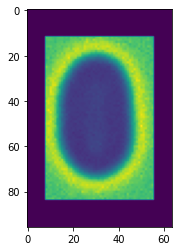

torch.Size([128, 1, 96, 64])


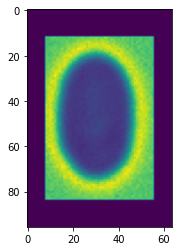

torch.Size([128, 1, 96, 64])


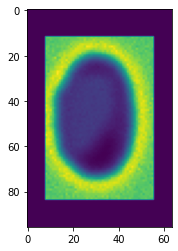

torch.Size([128, 1, 96, 64])


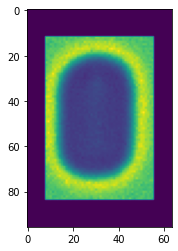

In [20]:
cnt = 0
for sem_img in test_loader:
    print(sem_img.shape)
    plt.imshow(sem_img[0][0])
    plt.show()
    cnt+=1
    if cnt == 5:
        break

In [21]:
ensembles = []
for model_name in model_names:
    imgs = []
    if model_name == "Unet":
        model_map = smp.Unet(in_channels=1, activation = 'sigmoid').to(device)
        model_map.load_state_dict(torch.load("./weight/map_model_"+model_name+".pt"))
    elif model_name == "Linknet":
        model_map = smp.Linknet(in_channels=1, activation = 'sigmoid').to(device)
        model_map.load_state_dict(torch.load("./weight/map_model_"+model_name+".pt"))
    for i, sem_img in tqdm(enumerate(test_loader), total=len(test_loader)):
        model_map.eval()
        with torch.no_grad():
            sem_img = sem_img.float().to(device)
            preds = model_map(sem_img)
            preds = preds[:, :, 12:(96-12), 8:(64-8)]
#             print(preds.shape)
#             plt.imshow(preds[0][0])
#             plt.show()
            imgs.append(preds.cpu().detach().numpy())
    pred_imgs = np.concatenate(imgs)
#     print(pred_probs.shape)
    ensembles.append(pred_imgs)


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

In [22]:
ensembles_imgs = np.mean(ensembles, axis=0)

In [23]:
def to_num(x):
    if x == 0:
        y = 140
    elif x == 1:
        y = 150
    elif x == 2:
        y = 160
    else:
        y = 170
    return y

In [24]:
nums = np.array([to_num(x) for x in cls]).reshape(-1,1,1,1)

In [25]:
outputs = ensembles_imgs * nums

In [26]:
os.makedirs('./submission', exist_ok=True)
os.chdir("./submission/")

In [27]:
path_img = []
for idx, path in tqdm(enumerate(test_sem_path_list)):
    cv2.imwrite(path.split("/")[-1], outputs[idx][0])
    path_img.append(path.split("/")[-1])

0it [00:00, ?it/s]

In [28]:
submission = zipfile.ZipFile("../submission_0915_OO.zip", 'w')
for path in path_img:
    submission.write(path)
submission.close()

In [29]:
os.chdir("../")

In [30]:
path_img

['000000.png',
 '000001.png',
 '000002.png',
 '000003.png',
 '000004.png',
 '000005.png',
 '000006.png',
 '000007.png',
 '000008.png',
 '000009.png',
 '000010.png',
 '000011.png',
 '000012.png',
 '000013.png',
 '000014.png',
 '000015.png',
 '000016.png',
 '000017.png',
 '000018.png',
 '000019.png',
 '000020.png',
 '000021.png',
 '000022.png',
 '000023.png',
 '000024.png',
 '000025.png',
 '000026.png',
 '000027.png',
 '000028.png',
 '000029.png',
 '000030.png',
 '000031.png',
 '000032.png',
 '000033.png',
 '000034.png',
 '000035.png',
 '000036.png',
 '000037.png',
 '000038.png',
 '000039.png',
 '000040.png',
 '000041.png',
 '000042.png',
 '000043.png',
 '000044.png',
 '000045.png',
 '000046.png',
 '000047.png',
 '000048.png',
 '000049.png',
 '000050.png',
 '000051.png',
 '000052.png',
 '000053.png',
 '000054.png',
 '000055.png',
 '000056.png',
 '000057.png',
 '000058.png',
 '000059.png',
 '000060.png',
 '000061.png',
 '000062.png',
 '000063.png',
 '000064.png',
 '000065.png',
 '000066.p

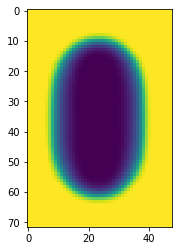

In [31]:
plt.imshow(cv2.imread('./submission/' + path_img[0], cv2.IMREAD_GRAYSCALE))

In [32]:
cv2.imread('./submission/' + path_img[0], cv2.IMREAD_GRAYSCALE)

array([[140, 140, 140, ..., 140, 140, 140],
       [140, 140, 140, ..., 140, 140, 140],
       [140, 140, 140, ..., 140, 140, 140],
       ...,
       [140, 140, 140, ..., 140, 140, 140],
       [140, 140, 140, ..., 140, 140, 140],
       [140, 140, 140, ..., 140, 140, 140]], dtype=uint8)

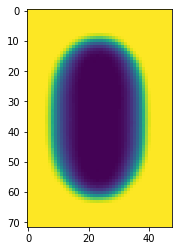

In [33]:
plt.imshow(cv2.imread('./submission/' + path_img[-1], cv2.IMREAD_GRAYSCALE))

In [34]:
cv2.imread('./submission/' + path_img[-1], cv2.IMREAD_GRAYSCALE)

array([[170, 170, 170, ..., 170, 170, 170],
       [170, 170, 170, ..., 170, 170, 170],
       [170, 170, 170, ..., 170, 170, 170],
       ...,
       [170, 170, 170, ..., 170, 170, 170],
       [170, 170, 170, ..., 170, 170, 170],
       [170, 170, 170, ..., 170, 170, 170]], dtype=uint8)